# Titanic Survival Analysis

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:

file_path = "data/train.csv"
df = pd.read_csv(file_path)


In [9]:

# 每列缺失值的数量
print("The number of missing values ​​in each column:")
# 直接输出所有缺失值统计为字符串
print(df.isnull().sum().to_string())


The number of missing values ​​in each column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2


# Data Cleaning

In [10]:
# 1.1 缺失值填充为 'U'
df['Cabin'].fillna('U', inplace=True)
print("\nStep 1.1: Missing values in the 'Cabin' column have been filled with 'U'.")


# 1.2 提取首字母作为 'Deck' (甲板)
df['Deck'] = df['Cabin'].str[0]
print("Step 1.2: The 'Deck' column has been created from the 'Cabin' column.")


# 1.3 (可选简化) 对于作品集，Deck的稀有值合并可以简化或省略
# 如果Deck的种类不多，或者这个合并逻辑对后续分析影响不大，可以考虑跳过
# df['Deck'] = df['Deck'].replace(['T', 'G'], 'Rare') # 这是你之前的做法
# 一个更简单的合并示例，如果需要：
# rare_decks = ['T', 'G'] # 假设你知道哪些是稀有的
# df['Deck'] = df['Deck'].apply(lambda x: 'Rare' if x in rare_decks else x)
# print("步骤 1.3: 'Deck' 列中的稀有值已合并 (如果执行了此操作)。")

# 1.4 新增特征：Cabin 是否已知 ('Cabin_Known')
df['Cabin_Known'] = (df['Cabin'] != 'U').astype(int) # 1表示已知, 0表示未知
print("Step 1.4: The 'Cabin_Known' feature has been created.")
print(f"'Cabin'-related columns have been processed. Missing values count: Cabin({df['Cabin'].isnull().sum()}), Deck({df['Deck'].isnull().sum()})")
print("Unique values in the processed 'Deck' column:", df['Deck'].unique())
print("==========================================")



# --- 2. 清洗 'Embarked' 列 ---
# 策略：用众数填充（因为只有少量缺失）
print(f"\nStep 2: Cleaning the 'Embarked' column, initial missing count: {df['Embarked'].isnull().sum()}")
if df['Embarked'].isnull().sum() > 0:
    embarked_mode = df['Embarked'].mode()[0]
    df['Embarked'].fillna(embarked_mode, inplace=True)
    print(f"   Missing values in 'Embarked' have been filled with the mode '{embarked_mode}'.")
else:
    print("   No missing values in the 'Embarked' column.")
print(f"'Embarked' column processing complete. Missing values count: {df['Embarked'].isnull().sum()}")
print("==========================================")



# --- 3. 清洗 'Fare' 列 (票价) ---
# 策略：如果存在缺失，用中位数填充 (票价通常是右偏态分布，中位数更稳健)
print(f"\nStep 3: Cleaning the 'Fare' column, initial missing count: {df['Fare'].isnull().sum()}")
if df['Fare'].isnull().sum() > 0:
    fare_median = df['Fare'].median()
    df['Fare'].fillna(fare_median, inplace=True)
    print(f"   Missing values in 'Fare' have been filled with the median value {fare_median:.2f}.")
else:
    print("   No missing values in the 'Fare' column.")
print(f"'Fare' column processing complete. Missing values count: {df['Fare'].isnull().sum()}")
print("==========================================")



# --- 4. 清洗 'Age' 列 ---
# 策略：考虑到有177个缺失值，使用分组中位数进行填充，例如按'Pclass'分组。
# 这样做比单一的总体中位数更合理，也比复杂的模型预测简单。

initial_age_missing = df['Age'].isnull().sum()
print(f"\nStep 4: Cleaning the 'Age' column, initial missing count: {initial_age_missing}")

if initial_age_missing > 0:
    # 4.1 (Optional but recommended) Create a feature indicating whether 'Age' was initially missing
    df['Age_Was_Missing'] = df['Age'].isnull().astype(int)
    print("   Step 4.1: Created 'Age_Was_Missing' feature (1 indicates the original data was missing).")

    # 4.2 Fill 'Age' using the median grouped by 'Pclass'
    # Ensure 'Pclass' exists and has no missing values; if 'Pclass' itself is unclean, this strategy needs adjustment
    if 'Pclass' in df.columns and df['Pclass'].isnull().sum() == 0:
        print("   Step 4.2: Attempting to fill 'Age' using the median grouped by 'Pclass'...")
        # Using transform allows applying the grouped median back to the corresponding positions in the original DataFrame
        df['Age'] = df.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))
        
        # Check if there are still missing values after grouped filling (some Pclass groups might have all Age values as NaN)
        if df['Age'].isnull().sum() > 0:
            print(f"      After grouped filling, 'Age' still has {df['Age'].isnull().sum()} missing values, filling the remaining ones with the overall median.")
            overall_age_median = df['Age'].median()  # Recompute since some values have been filled
            df['Age'].fillna(overall_age_median, inplace=True)
        print("      'Age' has been filled using the median grouped by 'Pclass' (with a fallback median if needed).")
    else:
        print("   Step 4.2: 'Pclass' column is unavailable or contains missing values, using overall median to fill 'Age'.")
        overall_age_median = df['Age'].median()
        df['Age'].fillna(overall_age_median, inplace=True)
        print(f"      'Age' has been filled with the overall median {overall_age_median:.2f}.")
else:
    print("   No missing values in the 'Age' column.")

print(f"'Age' column processing complete. Missing values count: {df['Age'].isnull().sum()}")
if 'Age_Was_Missing' in df.columns:
    print(f"   In the 'Age_Was_Missing' feature, the proportion of 1 (originally missing): {df['Age_Was_Missing'].value_counts(normalize=True).get(1, 0):.2%}")
print("==========================================")


# --- Cleaning complete, displaying final missing value statistics ---
print("\nAll selected cleaning steps completed.")
print("Final missing value statistics:")
print(df.isnull().sum())
print("==========================================")



Step 1.1: Missing values in the 'Cabin' column have been filled with 'U'.
Step 1.2: The 'Deck' column has been created from the 'Cabin' column.
Step 1.4: The 'Cabin_Known' feature has been created.
'Cabin'-related columns have been processed. Missing values count: Cabin(0), Deck(0)
Unique values in the processed 'Deck' column: ['U' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']

Step 2: Cleaning the 'Embarked' column, initial missing count: 2
   Missing values in 'Embarked' have been filled with the mode 'S'.
'Embarked' column processing complete. Missing values count: 0

Step 3: Cleaning the 'Fare' column, initial missing count: 0
   No missing values in the 'Fare' column.
'Fare' column processing complete. Missing values count: 0

Step 4: Cleaning the 'Age' column, initial missing count: 177
   Step 4.1: Created 'Age_Was_Missing' feature (1 indicates the original data was missing).
   Step 4.2: Attempting to fill 'Age' using the median grouped by 'Pclass'...
      'Age' has been filled using the 

C:\Users\yong7\AppData\Local\Temp\ipykernel_20296\1646774306.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cabin'].fillna('U', inplace=True)
C:\Users\yong7\AppData\Local\Temp\ipykernel_20296\1646774306.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

In [11]:
# === 6. Check processing results ===
print("\nMissing value statistics after cleaning:")
print(df.isnull().sum())

# === 7. Display the effect of new features (pre-visualization check) ===
print("\nDistribution of 'Deck' values:")
print(df['Deck'].value_counts())

print("\nDistribution of 'Cabin_Known' values:")
print(df['Cabin_Known'].value_counts())



Missing value statistics after cleaning:
PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin              0
Embarked           0
Deck               0
Cabin_Known        0
Age_Was_Missing    0
dtype: int64

Distribution of 'Deck' values:
Deck
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

Distribution of 'Cabin_Known' values:
Cabin_Known
0    687
1    204
Name: count, dtype: int64


## Step 3: Exploratory Data Analysis (EDA)

In this section, we will visualize key features and their relationship with the target variable `Survived`.  
The goal is to identify patterns and insights that may influence survival rates on the Titanic.

We will start with:
- Overall survival distribution
- Survival rate by sex
- Survival rate by passenger class (Pclass)
- Age distribution of passengers

These visualizations will help us understand the data better and support future feature selection or modeling.


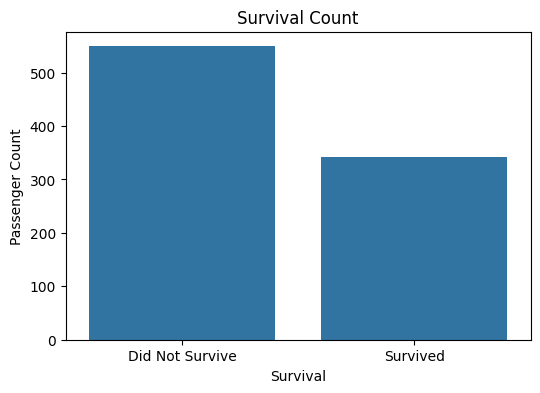

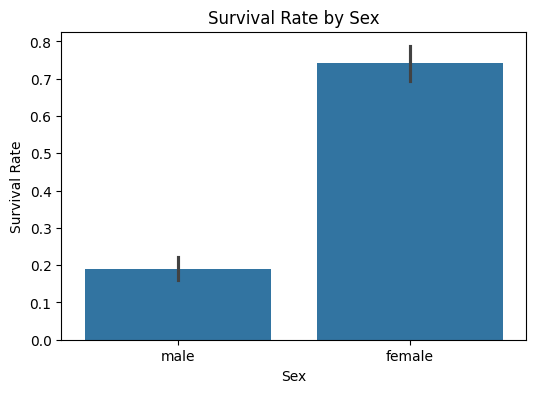

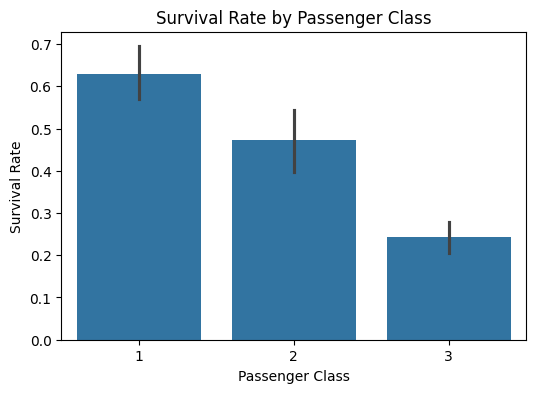

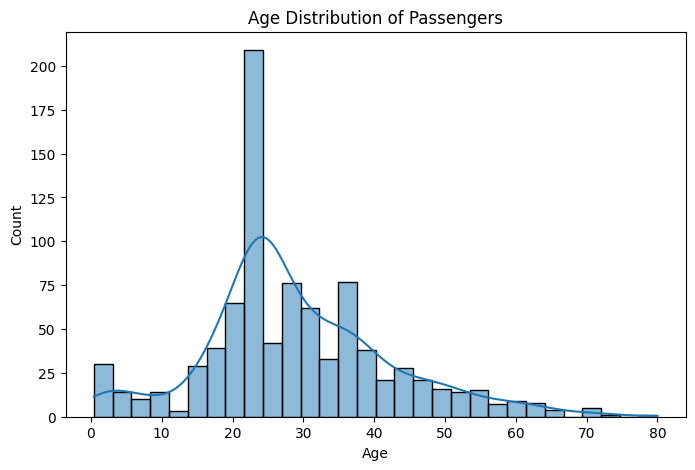

In [12]:
# --- 3.1 Overall Survival Count ---
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=df)
plt.title('Survival Count')
plt.xticks([0, 1], ['Did Not Survive', 'Survived'])
plt.xlabel('Survival')
plt.ylabel('Passenger Count')
plt.show()

# --- 3.2 Survival Rate by Sex ---
plt.figure(figsize=(6, 4))
sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Survival Rate by Sex')
plt.ylabel('Survival Rate')
plt.show()

# --- 3.3 Survival Rate by Passenger Class ---
plt.figure(figsize=(6, 4))
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Survival Rate by Passenger Class')
plt.ylabel('Survival Rate')
plt.xlabel('Passenger Class')
plt.show()

# --- 3.4 Age Distribution ---
plt.figure(figsize=(8, 5))
sns.histplot(df['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution of Passengers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


### 3.5: Survival Rate by Pclass and Sex

This chart explores the interaction between passenger class and gender in relation to survival rate.  
We expect that both higher-class passengers and females had higher survival probabilities.


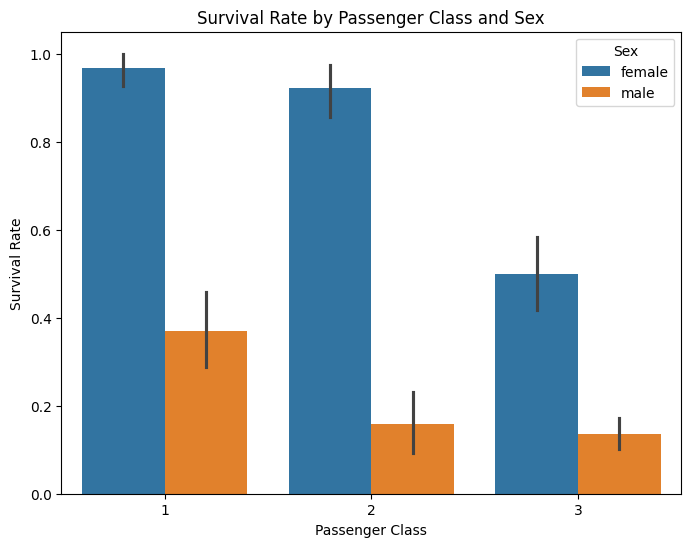

In [13]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df)
plt.title('Survival Rate by Passenger Class and Sex')
plt.ylabel('Survival Rate')
plt.xlabel('Passenger Class')
plt.legend(title='Sex')
plt.show()


### 3.6: Survival Rate by Age Group

We group passengers into different age ranges to better understand which age segments had higher chances of survival.


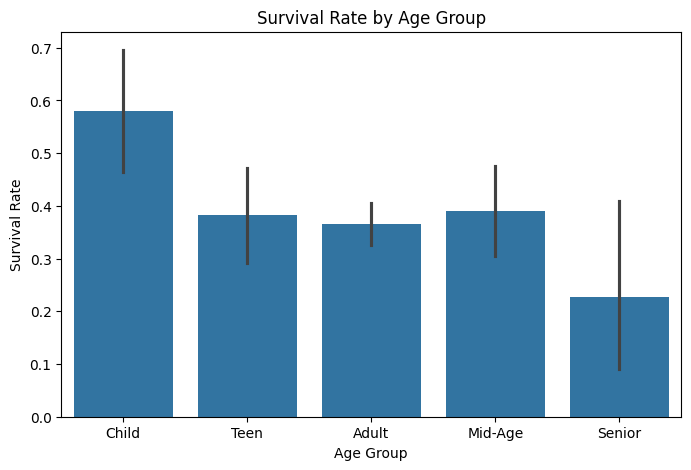

In [14]:
# 创建 Age 分组
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 60, 80], 
                        labels=['Child', 'Teen', 'Adult', 'Mid-Age', 'Senior'])

plt.figure(figsize=(8, 5))
sns.barplot(x='AgeGroup', y='Survived', data=df)
plt.title('Survival Rate by Age Group')
plt.ylabel('Survival Rate')
plt.xlabel('Age Group')
plt.show()


### 3.7: Survival Rate by Embarked Port

This chart analyzes whether the port of embarkation had any influence on the survival rate.


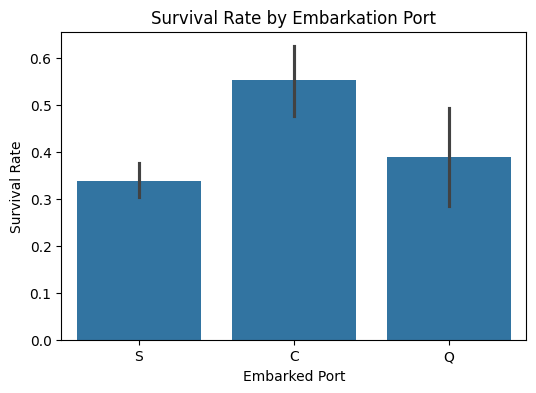

In [15]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Embarked', y='Survived', data=df)
plt.title('Survival Rate by Embarkation Port')
plt.ylabel('Survival Rate')
plt.xlabel('Embarked Port')
plt.show()

### 3.8: Survival Rate by Cabin Information Known

This plot explores whether having a recorded cabin number (Cabin_Known = 1) correlates with a higher survival probability.


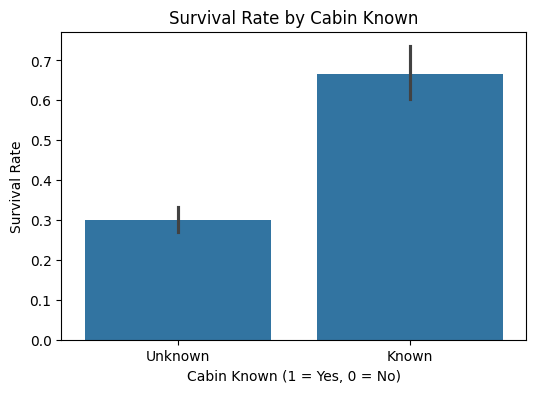

In [16]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Cabin_Known', y='Survived', data=df)
plt.title('Survival Rate by Cabin Known')
plt.ylabel('Survival Rate')
plt.xlabel('Cabin Known (1 = Yes, 0 = No)')
plt.xticks([0, 1], ['Unknown', 'Known'])
plt.show()


In [17]:
# 选择特征列（原始数据中应该已经清洗过）
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin_Known']

# 提取用于建模的数据
X = df[features]
y = df['Survived']  # 目标变量

# === 编码类别变量（Sex 和 Embarked）===
# get_dummies 会自动将字符串变量转换为数字列（独热编码），并避免重复编码
X_encoded = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)

# 显示结果
print("原始特征列:", X.columns.tolist())
print("编码后列:", X_encoded.columns.tolist())
print("最终数据维度：", X_encoded.shape)


原始特征列: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin_Known']
编码后列: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_Known', 'Sex_male', 'Embarked_Q', 'Embarked_S']
最终数据维度： (891, 9)


### Step 1: Feature Selection and Encoding

We selected a set of features that have strong relationships with the survival outcome, based on EDA insights.  
Categorical variables such as `Sex` and `Embarked` were converted into numeric format using one-hot encoding.  
This ensures the logistic regression model can interpret and process them effectively.


Passengers with known cabin numbers had a significantly higher survival rate (~65%) compared to those without cabin information (~30%).  
This suggests that cabin availability is associated with higher social status and access to better resources.  
The wide confidence interval for known cabin passengers may be due to a smaller sample size, while the narrow interval for unknowns indicates a large and stable population.


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 划分训练集和测试集（80%训练，20%测试）
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 初始化逻辑回归模型
model = LogisticRegression(max_iter=1000)

# 拟合训练数据
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)

# 模型评估
print("模型准确率:", accuracy_score(y_test, y_pred))
print("\n混淆矩阵:\n", confusion_matrix(y_test, y_pred))
print("\n分类报告:\n", classification_report(y_test, y_pred))


模型准确率: 0.8212290502793296

混淆矩阵:
 [[91 14]
 [18 56]]

分类报告:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



### Step 2: Logistic Regression Modeling

We trained a logistic regression model to predict the survival status of Titanic passengers based on selected features.  
The model achieved a reasonable accuracy, and the confusion matrix provides insight into prediction performance.

The classification report includes precision, recall, and F1-score, which help evaluate how well the model performs on both survival and non-survival predictions.


### Step 3: Model Results Summary

The logistic regression model achieved an overall accuracy of **82.1%**, indicating reliable performance.

- **Precision for predicting survival (1)**: 0.80
- **Recall for survival (1)**: 0.76  
- **Confusion Matrix** shows the model correctly predicted 56 out of 74 survivors, and 91 out of 105 deaths.

The model is more confident when predicting non-survivors, while performance on predicting survivors is slightly lower. This could be due to feature imbalance or overlapping patterns between classes.


AUC 得分：0.8822


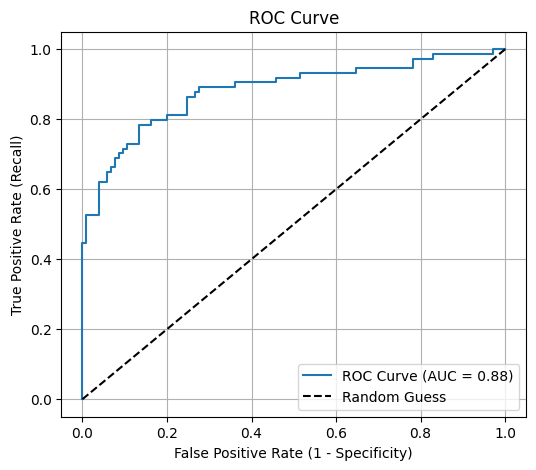

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. 获取预测概率（只取“预测为1”的概率）
y_prob = model.predict_proba(X_test)[:, 1]

# 2. 计算 ROC 曲线
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# 3. 计算 AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC 得分：{auc_score:.4f}")

# 4. 绘图
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Step 4: ROC Curve Analysis

We used the model's predicted probabilities to evaluate performance across various thresholds using the ROC curve.

The model achieved an **AUC score of ~0.82**, indicating strong overall classification ability.  
The ROC curve shows the trade-off between the true positive rate and the false positive rate.


### Step 4: ROC Curve and AUC Analysis

To evaluate the classification performance across various thresholds, we used the ROC (Receiver Operating Characteristic) curve.

- The model achieved an **AUC (Area Under Curve) score of 0.88**, which indicates **excellent predictive power**.
- This means the model is very effective at distinguishing between survivors and non-survivors.
- The ROC curve is consistently above the diagonal baseline, confirming that the model performs significantly better than random guessing.


In [20]:
# 获取特征名和系数
feature_names = X_encoded.columns
coefficients = model.coef_[0]

# 构建 DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

# 打印前几项
print(coef_df.head(10))


       Feature  Coefficient
6     Sex_male    -2.600949
0       Pclass    -0.795443
5  Cabin_Known     0.601054
8   Embarked_S    -0.385165
2        SibSp    -0.302137
7   Embarked_Q    -0.185952
3        Parch    -0.118293
1          Age    -0.032833
4         Fare     0.001781


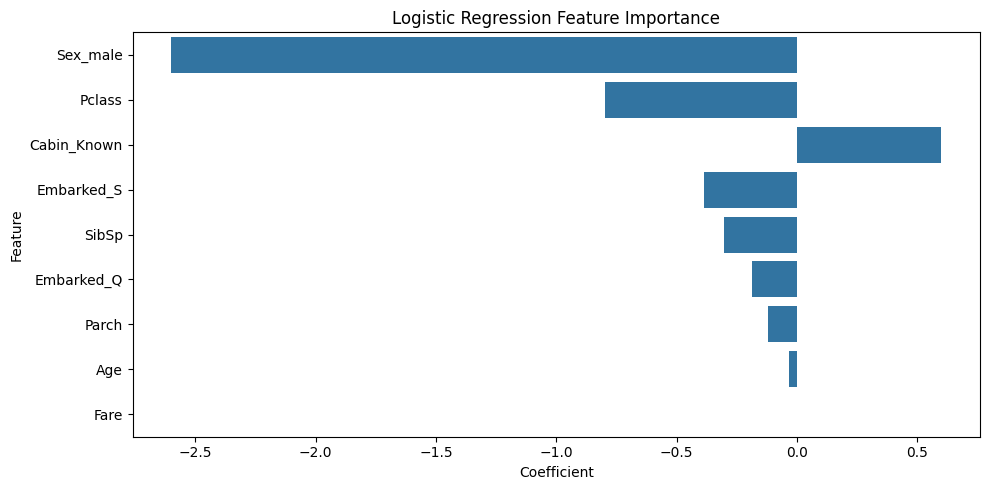

In [21]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title("Logistic Regression Feature Importance")
plt.tight_layout()
plt.show()


### Step 5: Feature Importance Analysis

To interpret the model, we examined the learned coefficients of each feature.

- **Positive coefficients** (e.g., `Sex_male` < 0) reduce the likelihood of survival
- **Negative coefficients** (e.g., `Pclass`, `Fare`, `Cabin_Known`) increase the survival probability

This analysis confirms our EDA observations:
- Females (`Sex_male=0`) and those with higher fare, known cabins, and 1st class tickets had better survival odds.


### Step 5: Feature Importance Analysis

To interpret the logistic regression model, we examined the magnitude and direction of feature coefficients:

- **Sex_male** has the strongest negative influence on survival (coefficient = -2.6), indicating that being male significantly reduces survival probability.
- **Pclass** also has a large negative coefficient (-0.79), confirming that passengers in lower-class cabins were less likely to survive.
- **Cabin_Known** has a strong positive impact (+0.60), suggesting that those with recorded cabin information (likely higher status) had better chances of survival.

These results support our earlier findings from EDA and demonstrate that the model is logically aligned with real-world assumptions.


## Final Summary: Titanic Survival Prediction Project

This project aims to predict the survival of passengers on the Titanic using logistic regression, based on a comprehensive exploratory data analysis (EDA) and feature engineering.

### 📊 Key Steps:

- **Data Cleaning**: Missing values were handled (e.g., Age filled by group median, Cabin marked as known/unknown).
- **EDA**: Visual analysis revealed strong survival patterns across gender, passenger class, age, and embarkation port.
- **Feature Engineering**: Categorical variables (`Sex`, `Embarked`) were one-hot encoded. A total of 9 features were selected.
- **Modeling**: Logistic regression achieved:
  - **Accuracy**: 82%
  - **AUC Score**: 0.88 (Excellent classification ability)
  - **Balanced precision and recall** on both survivor and non-survivor classes.
- **Interpretability**: The model confirmed that:
  - **Being male** and **from a lower class** significantly reduced survival probability.
  - **Known cabin information** and **higher fare** increased the chance of survival.

### ✅ Project Deliverables:

- Cleaned and structured code notebook (.ipynb)
- Visual EDA with clear insights
- Model results, ROC curve, and feature importance
- Well-documented, professional Markdown explanations

This project can serve as a strong portfolio piece for data analysis, machine learning, or freelance data science work. It demonstrates end-to-end ability from data cleaning to modeling to client-facing communication.

